# SpecMod Tutorial Notebook

This notebook is intended to guide the user on how to: 

1. preprocess data for input to SpecMod
2. process data to obtian seismic spectra 
3. model seismic spectra 

## [Preston New Road](http://www.earthquakes.bgs.ac.uk/research/PrestonNewRoadFAQ.html) Dataset
The dataset included is a set of records (from the [British Geological Survey](http://www.earthquakes.bgs.ac.uk/) and [University of Liverpool](http://www.inducedseismicity.co.uk/) seismic networks) of an $M_L$ 2.9 seismic event that occured in August, 2019 near the Preston New Road shale gas well site.

## Pre-processing 
For the calculation of spectra, SpecMod requires two ObsPy streams:
1. signal
2. noise

It requires the user to cut their waveforms for their specific needs e.g. 'n' second P-phase window and 'x' seconds of window of pre-signal noise. 

It is up to you to cut them, some things to consider are:

1. what phase is required - P or S?
2. what is the most appropriate channel (e.g. vertical (Z) for P, transverse (T) or east/west (E/W) for S)
3. do you trust your picks - are they real / theoretical - what are rough errors?
4. how many seconds of noise do you want - pre or post signal?
5. do I need to add station specific time shifts - is one station off consistently?
6. do I need to make my windows slightly larger to account for errors in location/timing/picking?

I have provided some basic tools, but you do not need to use them at all if you don't want to! It is only required that each trace in each stream has the following metadata (set *MANUALLY*) in their .stats dictionary:

    1. tr.stats['dep'] = depth (kilometers)
    2. tr.stats['olon'] = origin longitude (decimal degrees)
    3. tr.stats['olat'] = origin latitude (decimal degrees)
    4. tr.stats['olat'] = origin latitude (decimal degrees)
    4. tr.stats['slon'] = station longitude (decimal degrees)
    5. tr.stats['slat'] = station latitude (decimal degrees)
    6. tr.stats['selv'] = station elevation (meters)
    7. tr.stats['repi'] = epicentral distance (source-reciever) (kilometers)
    6. tr.stats['rhyp'] = hypocentral distance (source-reciever) (kilometers)

In [1]:
import os
os.chdir("../")
import specmod.utils as ut
import specmod.PreProcess as pre
from obspy import read, read_inventory, UTCDateTime
os.chdir("Tutorial")
import matplotlib.pyplot as plt

In [2]:
# Define parent directories
pdata = "Data/2019-08-26T07:30:47.0"
pinv = "MetaData/"

In [3]:
# Space for custom classes / functions


In [4]:
# Earthquake origin information
olat, olon, odep, otime = 53.784, -2.967, 2.1, UTCDateTime("2019-08-26T07:49:24.2")

In [5]:
# Read in our data (East)
stE, stN = read(os.path.join(pdata, '*HHE*'), format='mseed'), read(os.path.join(pdata, '*HHN*'), format='mseed')
st = stE + stN
# Read in the inventory (station XML file)
inv = read_inventory(os.path.join(pinv, "pnr_inventory.xml"), "stationxml")

In [6]:
# set the distances for the stream (required for theoreticals)
pre.set_stream_distance(st, olat, olon, odep, otime, inventory=inv, dtype="mseed")

# set the picks
pre.set_picks_from_pyrocko(st, os.path.join(pdata, "2019-08-26T07:30:47.000000.picks"))

# remove the traces with no s-pick 
for tr in st:
    try:
        tr.stats['s_time']
    except KeyError:
        st.remove(tr)

/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/obspy/core/inventory/network.py:324: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


In [7]:
# pre-process
st.detrend("linear")
st.detrend("demean")
st.taper(0.05)
st.remove_response(inv)

/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)


28 Trace(s) in Stream:

LV.L001..HHE | 2019-08-26T07:30:46.900000Z - 2019-08-26T07:30:53.900000Z | 100.0 Hz, 701 samples
...
(26 other traces)
...
UR.AQ10.00.HHN | 2019-08-26T07:30:49.500000Z - 2019-08-26T07:30:56.500000Z | 100.0 Hz, 701 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

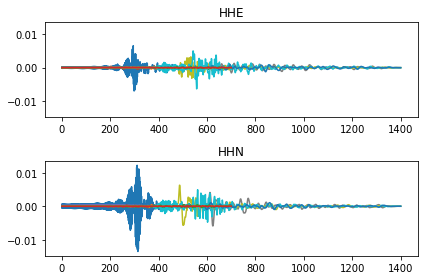

In [8]:
# quick sanity check
fig, ax = plt.subplots(2,1, sharey=True)
import matplotlib.pyplot as plt
for trE, trN in zip(st.select(channel="HHE"), st.select(channel="HHN")):
    
    ax[0].plot(trE.data)
    ax[1].plot(trN.data)
    
ax[0].set_title(f"{trE.id.split('.')[-1]}")
ax[1].set_title(f"{trN.id.split('.')[-1]}")
fig.tight_layout()

In [9]:
st[0].stats

         network: LV
         station: L001
        location: 
         channel: HHE
       starttime: 2019-08-26T07:30:46.900000Z
         endtime: 2019-08-26T07:30:53.900000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 701
           calib: 1.0
         _format: MSEED
         azimuth: 31.51024312303872
    back_azimuth: 211.54068284659363
             dep: 2.1
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 6, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 3072})
            olat: 53.784
            olon: -2.967
           otime: 2019-08-26T07:49:24.200000Z
          p_time: 2019-08-26T07:30:48.729390Z
      processing: ["ObsPy 1.2.1: detrend(options={}::type='linear')", "ObsPy 1.2.1: detrend(options={}::type='demean')", "ObsPy 1.2.1: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')", "ObsPy 1.2.1: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x7fdd1

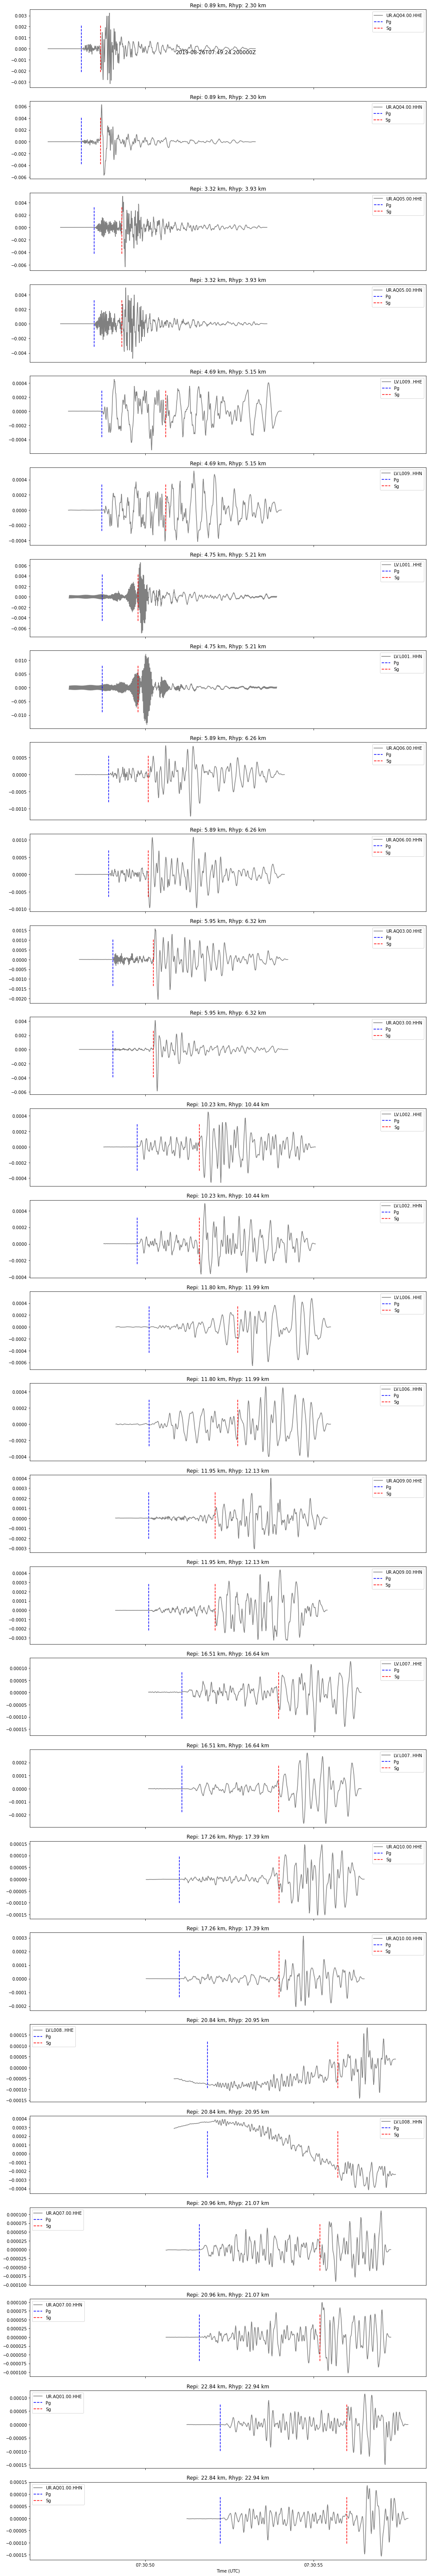

In [10]:
ut.plot_traces(st.copy(), plot_theoreticals=True, conv=1)

In [11]:
# cut the s-wave
sig = pre.get_signal(st, pre.cut_s, bf=0, rafp=1, tafs=1, time_after='relative_ps')
noise = pre.get_noise_s(st, bf=1, bshift=0)

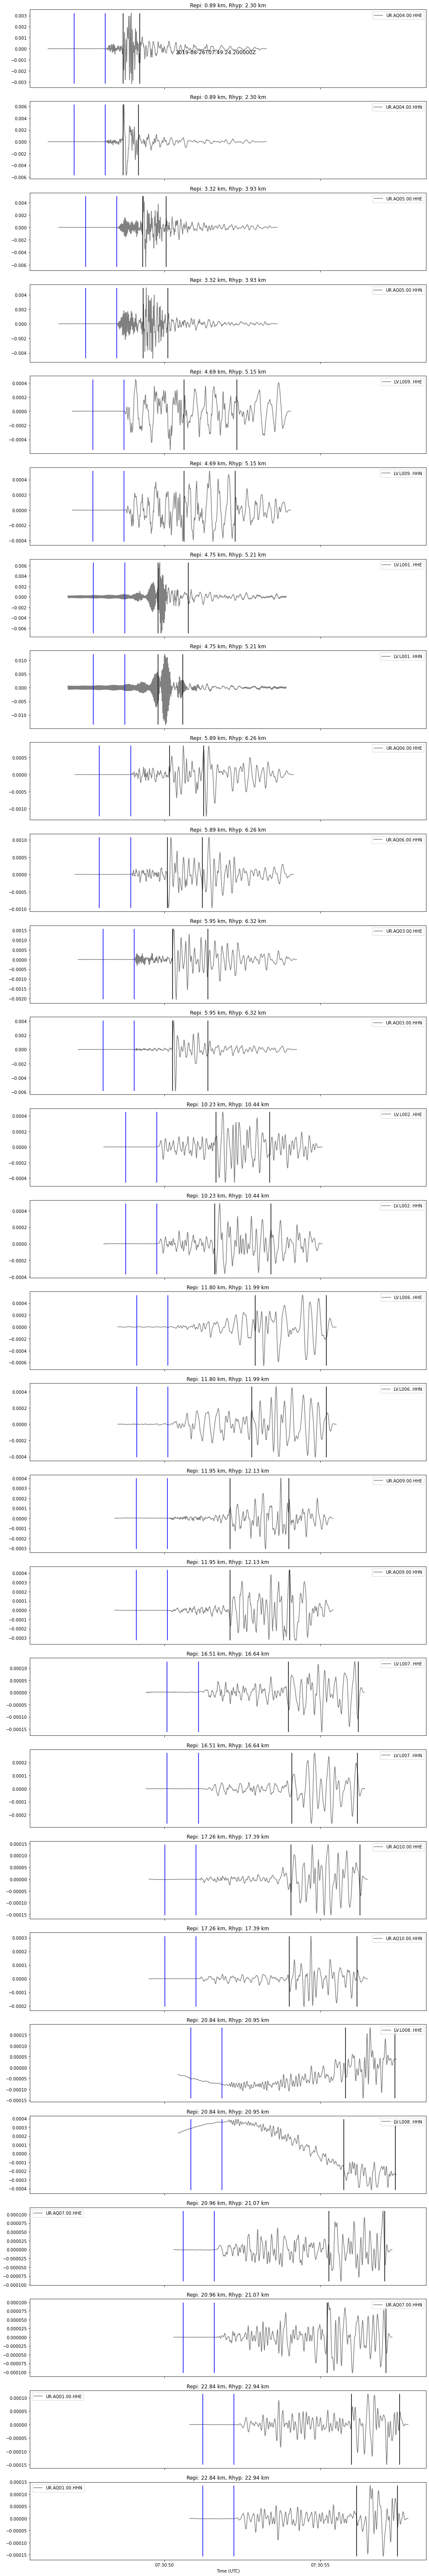

In [12]:
ut.plot_traces(st.copy(), plot_windows=True, conv=1, sig=sig, noise=noise)

# PART 2 - Process Spectra
Now the hard work is done, SpecMod will do the heavy lifting of spectral analysis for you.
This section will cover:
 1. computing spectra via multitaper spectral estimation - see [mstspec](https://krischer.github.io/mtspec/) and [(Prieto, G. A., R. L. Parker, F. L. Vernon, 2009)](https://www.sciencedirect.com/science/article/pii/S0098300409000077?casa_token=L5S-5ypseeoAAAAA:U5OrabDpc1Wvnv3CpCXxFo_Lk0daY8vs8PYpOsCFgWr6t7BzPII1-SY5sLTybEGbJ1EcZTPgzUR4)
 2. saving the event spectra
 3. data manipulation (power spectra to amplitude, time integration/differentiation)
 5. visualisation

In [13]:
# import the spectral module to calculate spectra from signal and noise windows
os.chdir("../")
import specmod.Spectral as sp
os.chdir("Tutorial")

In [14]:
outpdir = "Spectra/"


### WARNING!
You may pad the signal and noise before passing through to mtspec but I have had better results by NOT padding. Especially for instruments with v high sampling rate. It seems to introduce a non-linear ringing into the signal. If you want to pad, uncomment the code in the cell below.


In [15]:
# pad signal and noise
# tp = 0.5 # total pad in seconds
# for trs, trn in zip(sig, noise): # applies half to each end.
#     trs.trim(starttime=trs.stats.wstart-tp/2, endtime=trs.stats.wend+tp/2, pad=True, fill_value=0)
#     trn.trim(starttime=trs.stats.wstart-tp/2, endtime=trs.stats.wend+tp/2, pad=True, fill_value=0)

It is highly recommended you review see [mstspec](https://krischer.github.io/mtspec/) and [(Prieto, G. A., R. L. Parker, F. L. Vernon, 2009)](https://www.sciencedirect.com/science/article/pii/S0098300409000077?casa_token=L5S-5ypseeoAAAAA:U5OrabDpc1Wvnv3CpCXxFo_Lk0daY8vs8PYpOsCFgWr6t7BzPII1-SY5sLTybEGbJ1EcZTPgzUR4)​ to understand what the keyword arguments mean. This tutorial is not intended as a review of multitaper spectral estimation. You can use these parameters and experiment with different combinations. We recommend changing quadratic to true, and switching tapers from 1 - 10 to see the difference. 

In [16]:
spectra = sp.Spectra.from_streams(sig, noise, quadratic=False, number_of_tapers=5)

Doing LV.L001..HHE
Doing LV.L002..HHE
Doing LV.L006..HHE
Doing LV.L007..HHE
Doing LV.L008..HHE
Doing LV.L009..HHE
Doing UR.AQ01.00.HHE
Doing UR.AQ03.00.HHE
Doing UR.AQ04.00.HHE
Doing UR.AQ05.00.HHE


/Users/jholt/Documents/James/Job Search/Interview Files/IMS /SpecMod/specmod/Spectral.py:149: RuntimeWarning: Mean of empty slice.
  a = 10**np.log10(self.amp[(self.freq>=bb)&(self.freq<=bf)]).mean()
/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Doing UR.AQ06.00.HHE
Doing UR.AQ07.00.HHE
Doing UR.AQ09.00.HHE
Doing UR.AQ10.00.HHE
Doing LV.L001..HHN
Doing LV.L002..HHN
Doing LV.L006..HHN
Doing LV.L007..HHN
Doing LV.L008..HHN
Doing LV.L009..HHN
Doing UR.AQ01.00.HHN
Doing UR.AQ03.00.HHN
Doing UR.AQ04.00.HHN
Doing UR.AQ05.00.HHN
Doing UR.AQ06.00.HHN
Doing UR.AQ07.00.HHN
Doing UR.AQ09.00.HHN
Doing UR.AQ10.00.HHN


### Automatic Signal bandwidth estimation
SpecMod automatically computes the 'optimal' signal bandwidth for modelling. This is currently set to where the signal-to-noise ratio is continuously $\geq$ 3. You can edit this value in specmod.config file by changing SNR_TOLERANCE in the SPECTRAL dictionary.

### Automatic Noise Rotation
Sometimes the signal and noise spectrum do not meet at the low, or high frequency end. This is problematic for determining the best noise window. We ensure they meet by performing a 'rotation' of the noise spectrum at each end until it meets the signal spectrum. The 'aggressiveness' of the rotation is controlled by increasing or decreasing the difference of the 'space' value in ROT_PARS. The space is the range of normalised frequencies to rotate over. If the difference in space is smaller the rotation will be performed closer to the center frequency of the spectrum and vice versa. The 'inc' parameter contriols the increment of rotation that is performed before a check is made to determine if the signal and noise spectrum are meeting or not. Increasing 'inc' will increase the compute time of the rotation, but will mean that you are less likely to 'overshoot' the rotation. This can be especically important for shorter bandwidth signals.

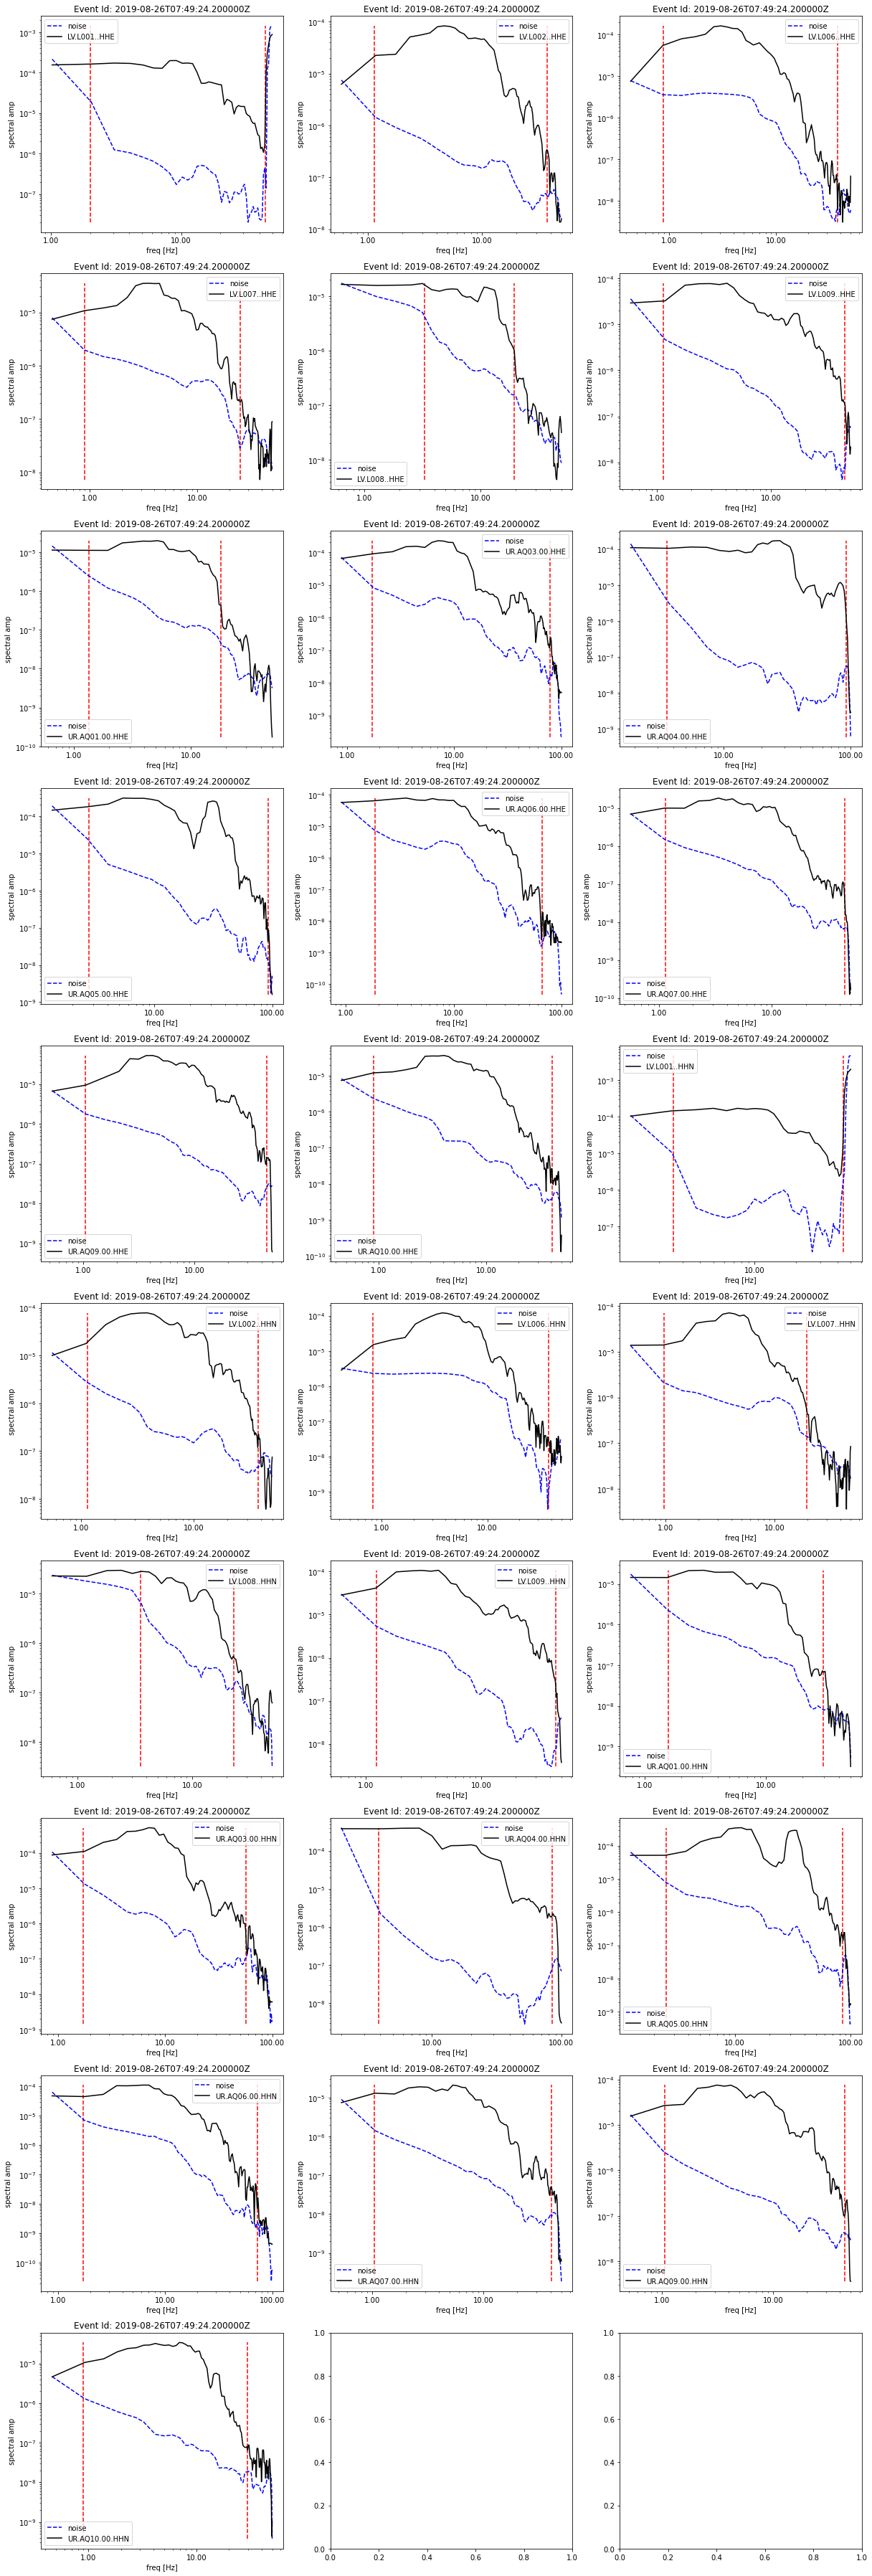

In [17]:
out = spectra.quick_vis()

You can currently save the spectra out to a binary format called 'Pickle'.

In [18]:
# save the spectra 
spectra.write_spectra(os.path.join(outpdir, "2019-08-26T07:30:47.0"), spectra, method='pickle')
os.listdir(outpdir) # list the directory for proof!

['2019-08-26T07:30:47.0.spec', 'FlatFiles']

You MUST be careful when reading pickle files. Only read ones that you made or know who made them.

In [19]:
spectra = sp.Spectra.read_spectra(os.path.join(outpdir, "2019-08-26T07:30:47.0"+".spec"), method='pickle', skip_warning=True)

You can integrate to displacement easily. Assuming you removed the response to ground velocity, integrate once.

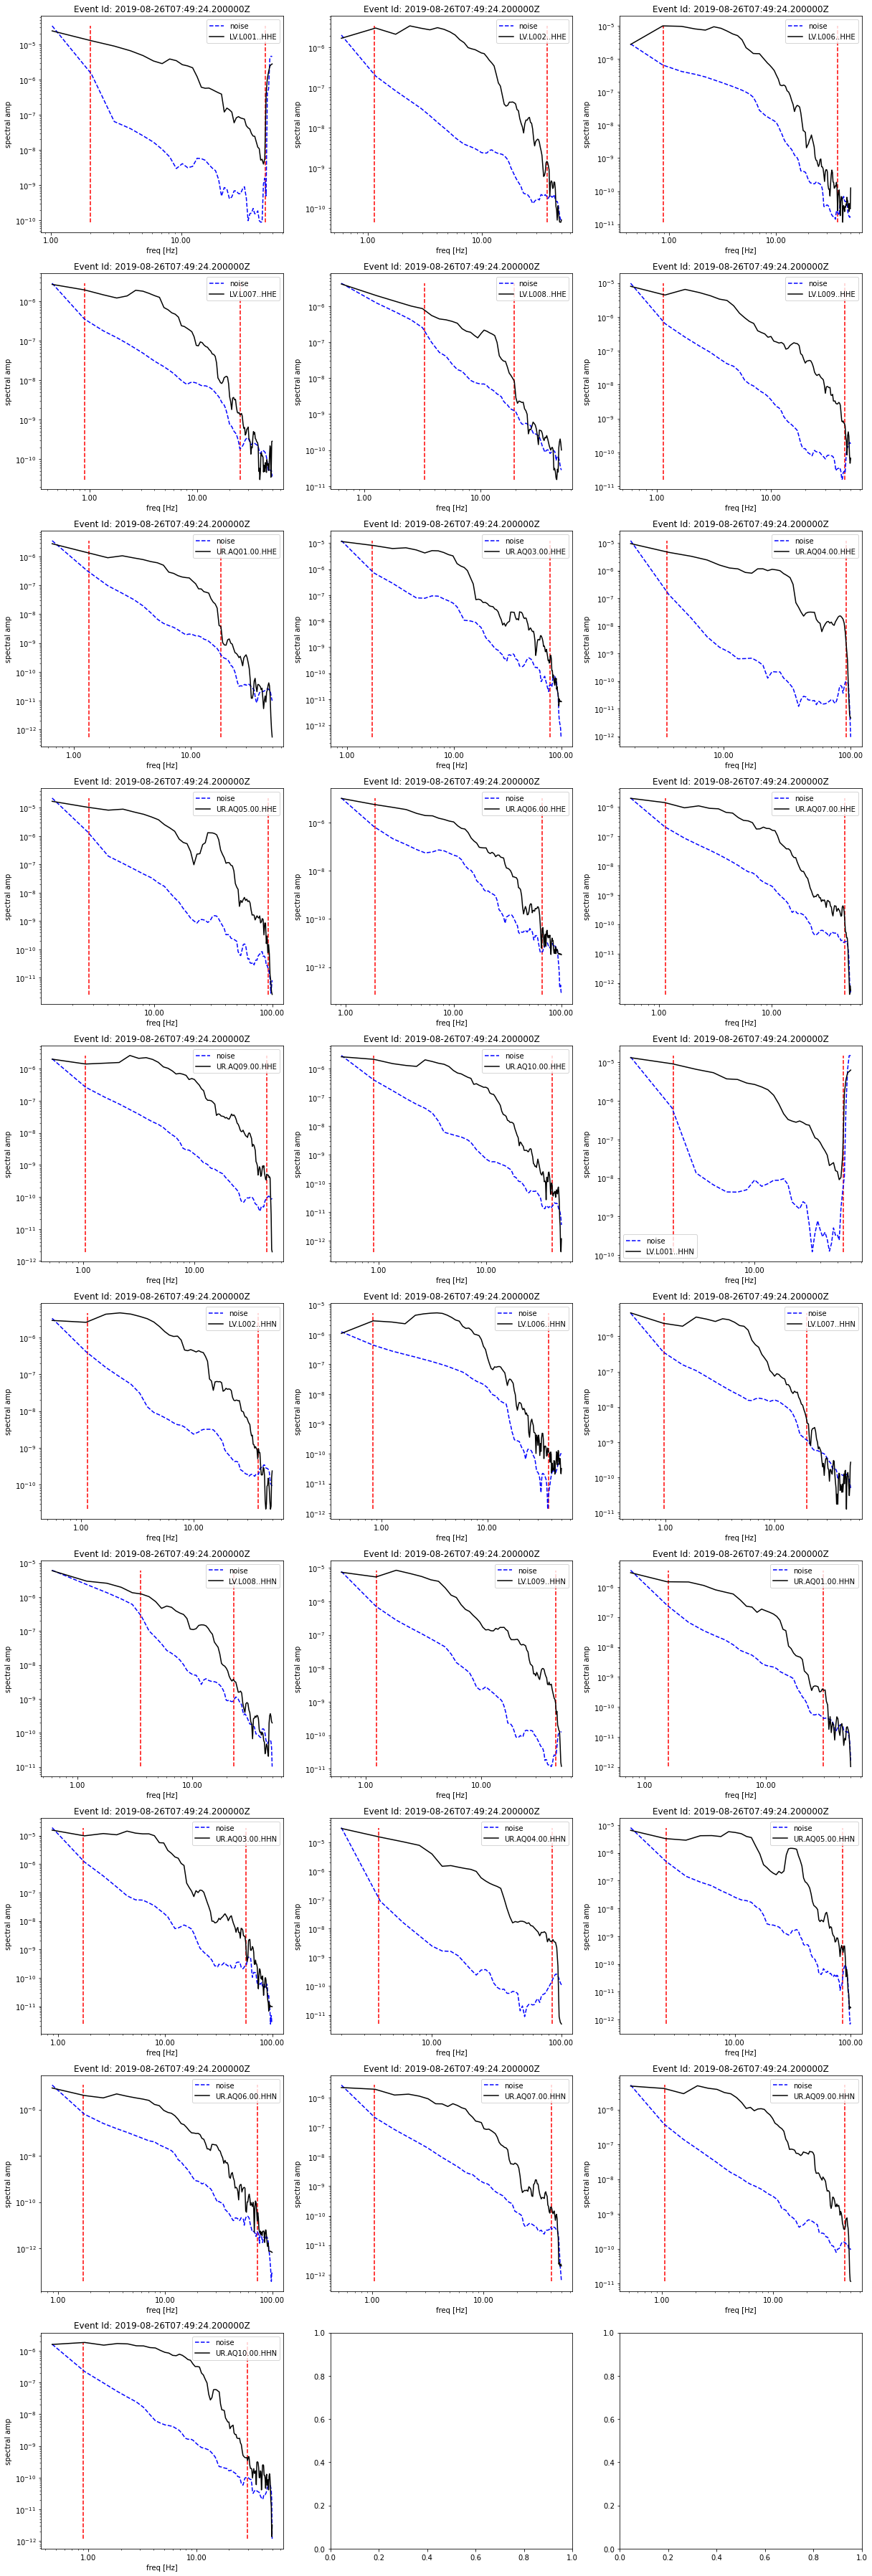

In [20]:
# you can integrate
spectra.inte()
out = spectra.quick_vis()

You can go back easily!

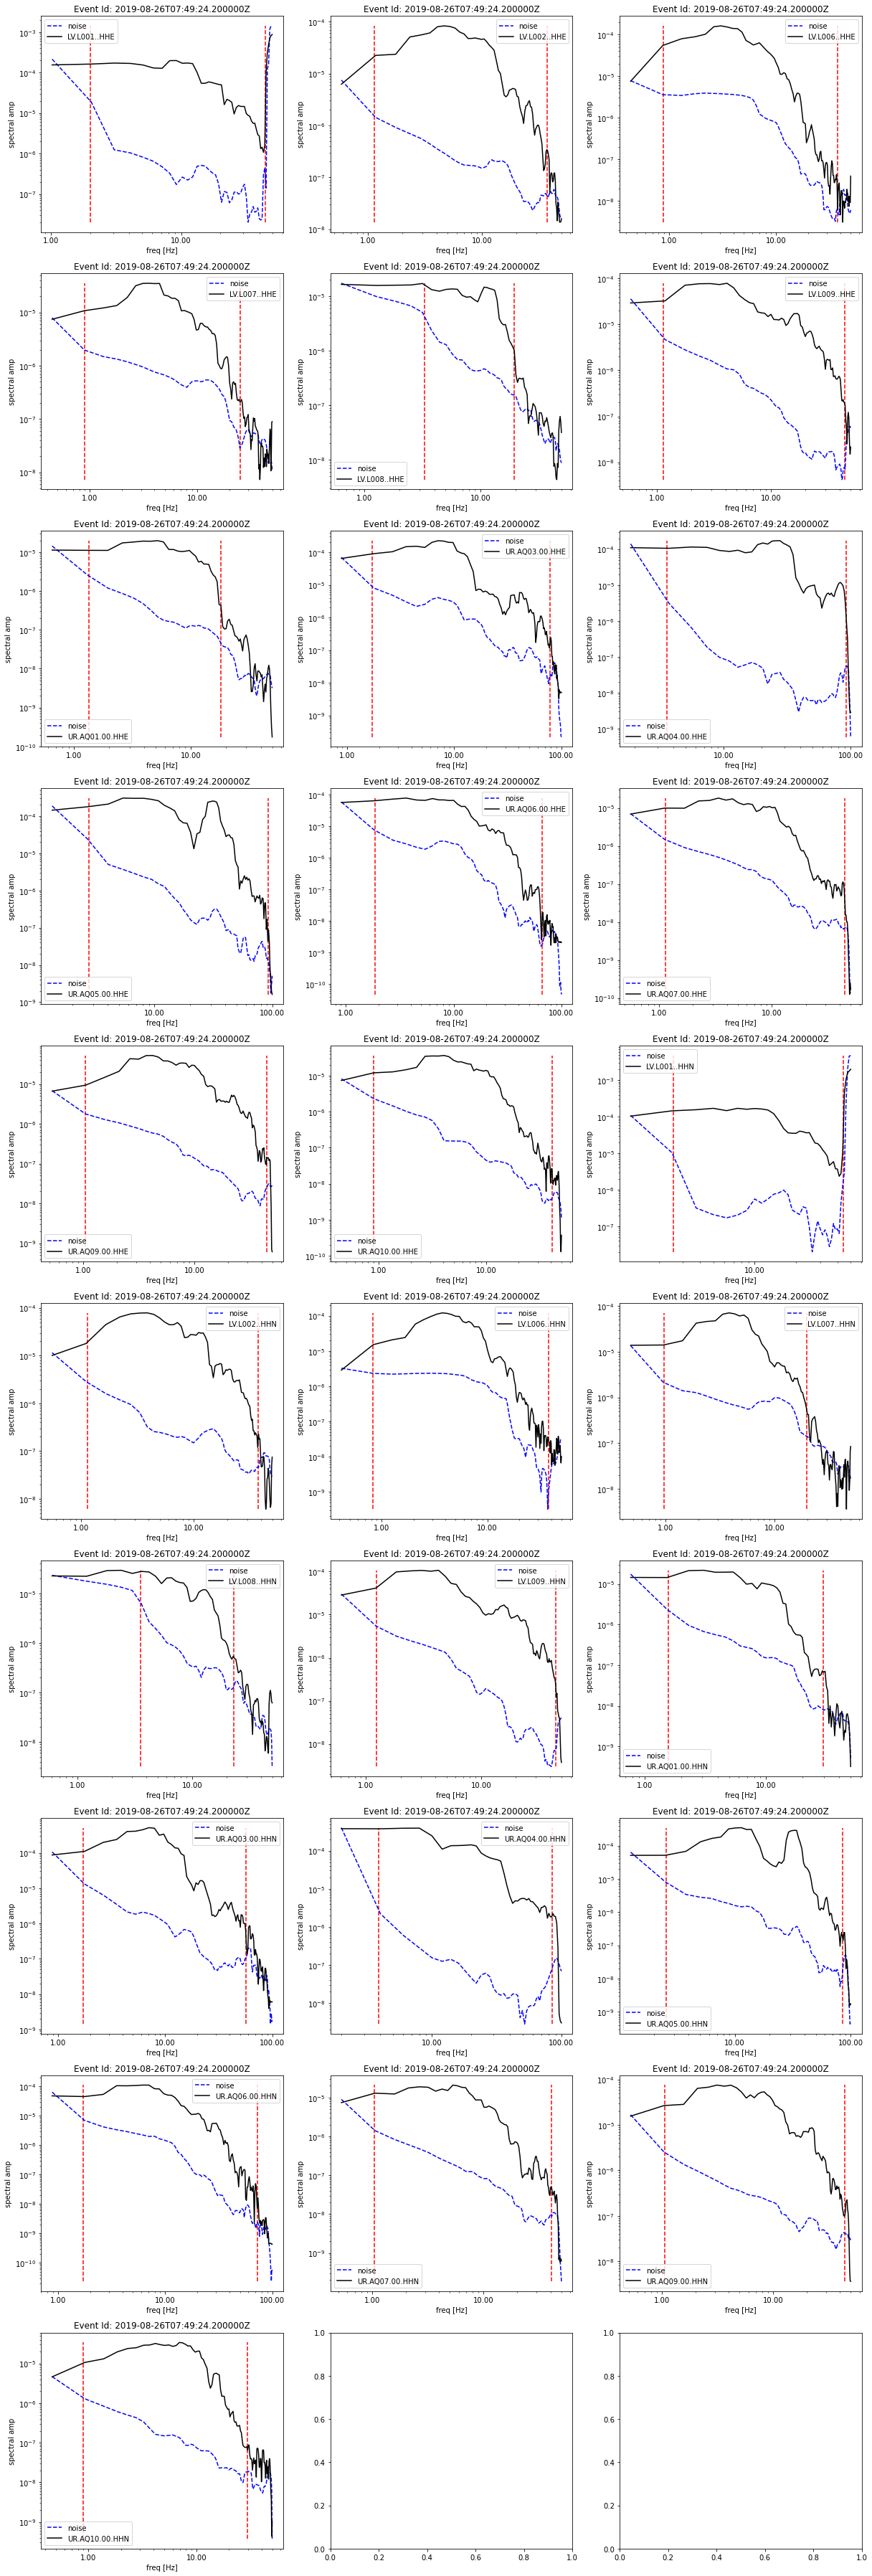

In [21]:
spectra = sp.Spectra.read_spectra(os.path.join(outpdir, "2019-08-26T07:30:47.0"+".spec"), method='pickle', skip_warning=True)
out = spectra.quick_vis()

# PART 3 - Modeling Spectra

This section will cover:
 1. Fitting a basic spectral model to our real processed sesimic spectra 
 
We recommend looking at the docs for [lmfit](https://lmfit.github.io/lmfit-py/) to understand the code being used to fit spectra in the background. 

In [22]:
# import the spectral module to calculate spectra from signal and noise windows
os.chdir("../")
import specmod.Fitting as fit
import specmod.Models as mod
import specmod.ModelGuess as g
os.chdir("Tutorial")

Spectral Fitting is a little more involved, right now only simple models can be fit:

$A(f) = \frac{{\Omega_0}} {(1+(f/f_c)^{\gamma n})^\gamma}*\exp(-\pi f t^*)$, where the free parameters are $\Omega_0$, $f_c$ and $t^*$.

First, create a guess for those parameters for each spectrum. Conveniently, I have included a function to help you with this...


In [23]:
guess = g.create_simple_guess(spectra)

This next step will initialse the fitting process.

In [24]:
fits = fit.FitSpectra(spectra, mod.simple_model, guess, fit_bins=True)
fits.set_bounds('ts', min=0.0001) # you can set bounds for parameters (not sensible to have a ts < 0)


Then we will fit the spectra. For this we will use [Powell's minimisation technique](https://en.wikipedia.org/wiki/Powell%27s_method). 
The advantage of using the [lmfit](https://lmfit.github.io/lmfit-py/) package is that it supports many search methods.
Check the docs for lmfit for more info!

In [25]:
fits.fit_spectra(method='powell')

Visualise the fits.

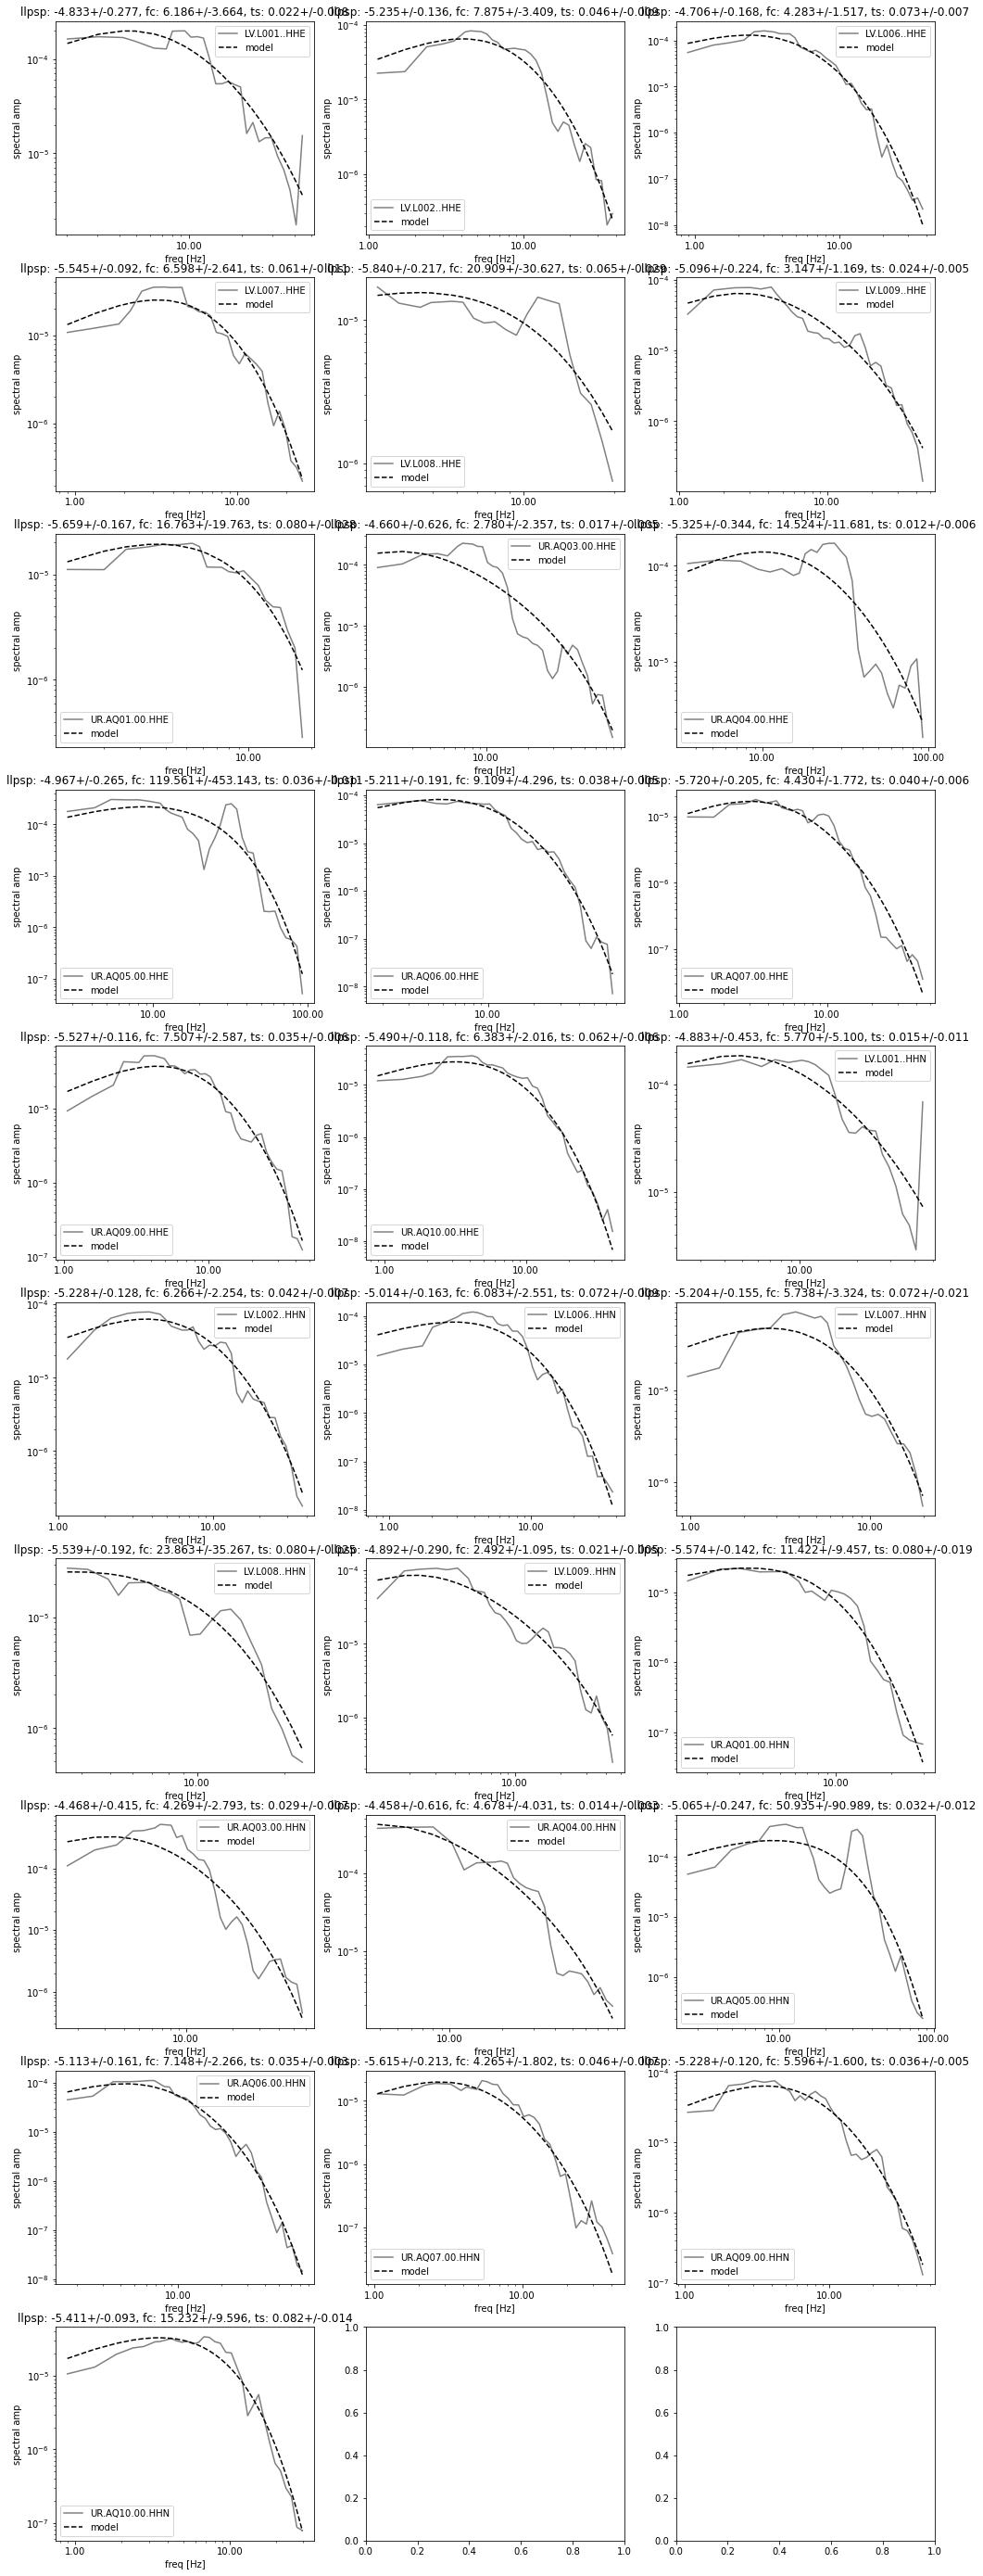

In [26]:
fits.quick_vis()

Then inspect the output as a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [27]:
fits.table

sampling_rate  delta                    starttime  \
0           100.0  0.010  2019-08-26T07:30:49.790000Z   
1           100.0  0.010  2019-08-26T07:30:51.660000Z   
2           100.0  0.010  2019-08-26T07:30:52.920000Z   
3           100.0  0.010  2019-08-26T07:30:53.980000Z   
4           100.0  0.010  2019-08-26T07:30:55.800000Z   
5           100.0  0.010  2019-08-26T07:30:50.640000Z   
6           100.0  0.010  2019-08-26T07:30:56.000000Z   
7           200.0  0.005  2019-08-26T07:30:50.270000Z   
8           200.0  0.005  2019-08-26T07:30:48.680000Z   
9           200.0  0.005  2019-08-26T07:30:49.315000Z   
10          200.0  0.005  2019-08-26T07:30:50.165000Z   
11          100.0  0.010  2019-08-26T07:30:55.280000Z   
12          100.0  0.010  2019-08-26T07:30:52.110000Z   
13          100.0  0.010  2019-08-26T07:30:54.060000Z   
14          100.0  0.010  2019-08-26T07:30:49.790000Z   
15          100.0  0.010  2019-08-26T07:30:51.620000Z   
16          100.0  0.010  2019-08-26T07:30:52.800000Z   
17          100.0  0.010  2019-08-26T07:30:54.090000Z   
18          100.0  0.010  2019-08-26T07:30:55.750000Z   
19          100.0  0.010  2019-08-26T07:30:50.640000Z   
20          100.0  0.010  2019-08-26T07:30:56.170000Z   
21          200.0  0.005  2019-08-26T07:30:50.265000Z   
22          200.0  0.005  2019-08-26T07:30:48.680000Z   
23          200.0  0.005  2019-08-26T07:30:49.320000Z   
24          200.0  0.005  2019-08-26T07:30:50.100000Z   
25          100.0  0.010  2019-08-26T07:30:55.220000Z   
26          100.0  0.010  2019-08-26T07:30:52.110000Z   
27          100.0  0.010  2019-08-26T07:30:54.010000Z   

                        endtime  npts network station location channel  \
0   2019-08-26T07:30:50.760000Z    98      LV    L001              HHE   
1   2019-08-26T07:30:53.370000Z   172      LV    L002              HHE   
2   2019-08-26T07:30:55.200000Z   229      LV    L006              HHE   
3   2019-08-26T07:30:56.210000Z   224      LV    L007              HHE   
4   2019-08-26T07:30:57.380000Z   159      LV    L008              HHE   
5   2019-08-26T07:30:52.330000Z   170      LV    L009              HHE   
6   2019-08-26T07:30:57.540000Z   155      UR    AQ01       00     HHE   
7   2019-08-26T07:30:51.395000Z   226      UR    AQ03       00     HHE   
8   2019-08-26T07:30:49.215000Z   108      UR    AQ04       00     HHE   
9   2019-08-26T07:30:50.055000Z   149      UR    AQ05       00     HHE   
10  2019-08-26T07:30:51.260000Z   220      UR    AQ06       00     HHE   
11  2019-08-26T07:30:57.060000Z   179      UR    AQ07       00     HHE   
12  2019-08-26T07:30:54.000000Z   190      UR    AQ09       00     HHE   
13  2019-08-26T07:30:56.270000Z   222      UR    AQ10       00     HHE   
14  2019-08-26T07:30:50.590000Z    81      LV    L001              HHN   
15  2019-08-26T07:30:53.410000Z   180      LV    L002              HHN   
16  2019-08-26T07:30:55.200000Z   241      LV    L006              HHN   
17  2019-08-26T07:30:56.180000Z   210      LV    L007              HHN   
18  2019-08-26T07:30:57.400000Z   166      LV    L008              HHN   
19  2019-08-26T07:30:52.270000Z   164      LV    L009              HHN   
20  2019-08-26T07:30:57.470000Z   131      UR    AQ01       00     HHN   
21  2019-08-26T07:30:51.395000Z   227      UR    AQ03       00     HHN   
22  2019-08-26T07:30:49.175000Z   100      UR    AQ04       00     HHN   
23  2019-08-26T07:30:50.110000Z   159      UR    AQ05       00     HHN   
24  2019-08-26T07:30:51.225000Z   226      UR    AQ06       00     HHN   
25  2019-08-26T07:30:57.100000Z   189      UR    AQ07       00     HHN   
26  2019-08-26T07:30:54.020000Z   192      UR    AQ09       00     HHN   
27  2019-08-26T07:30:56.170000Z   217      UR    AQ10       00     HHN   

                                                mseed  ... llpsp-stderr  \
0   AttribDict({'dataquality': 'D', 'number_of_rec...  ...     0.138747   
1   AttribDict({'dataquality': 'D', 'number_of_rec...

Finally, save the output!

In [28]:
fits.write_flatfile(os.path.join(outpdir, "FlatFiles", fits.spectra.event + ".csv"), fits)

In [29]:
os.listdir(os.path.join(outpdir, "FlatFiles"))

['2019-08-26T07:49:24.200000Z.csv']